# Firing Rate Analyses

## Transform spike counts into firing rates

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve

##### Load spike timing data

In [2]:
dset = xr.load_dataset("../../data/steinmetz_2016-12-14_Cori.nc")

cols = ["spike_trial", "spike_cell", "spike_time"]
spike_time_df = dset[cols].to_dataframe().reset_index()

# Get the trial number for the active trials
active_trial_df = dset["active_trials"].to_dataframe().reset_index()
active_trials = active_trial_df.trial[active_trial_df.active_trials]

##### Transform this into a 3D array with dims `(neurons, trials, time)`

In [3]:
time_bin = dset.bin_size
spike_time_df['time_bin'] = (spike_time_df["spike_time"] // time_bin).astype(int)

# Group by neuron, trial, and time_bin, and count spikes
grouped = spike_time_df.groupby(['spike_cell', 'spike_trial', 'time_bin']).size().reset_index(name='spike_count')

# Pivot to create a 3D matrix
pivot_df = grouped.pivot_table(index='spike_cell', columns=['spike_trial', 'time_bin'], values='spike_count', fill_value=0)

# Convert to a numpy array and reshape
spike_array = pivot_df.values.reshape(pivot_df.shape[0], spike_time_df['spike_trial'].nunique(), spike_time_df['time_bin'].nunique())

##### Plot the population activity for all trials and over time with a heatmap.

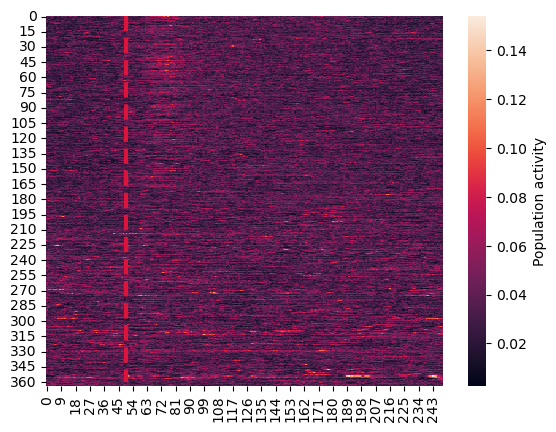

In [4]:
sns.heatmap(spike_array.mean(axis=0), cbar_kws={"label": "Population activity"})
plt.plot([50, 50], [0, 360], color="crimson", lw=3, ls="--")

##### In order to go from spike counts to firing rates we need a filter to convolve our spike count array with. Let's create a Gaussian filter for this.

In [4]:
window_width = int(.1 / time_bin)  # example window width of 0.5 seconds
window = np.exp(-np.linspace(-2, 2, window_width) ** 2)
window /= window.sum()

##### How does the filter look like?

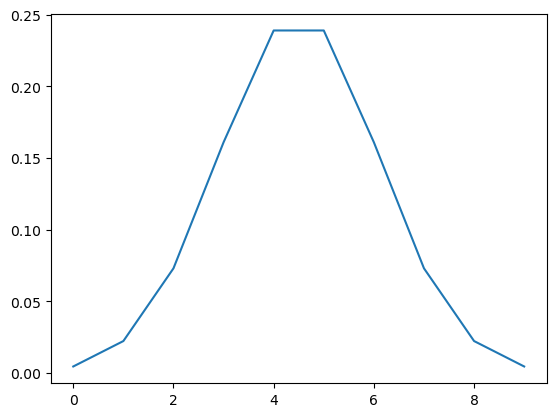

In [5]:
plt.plot(window)

##### Create the firing rate array by convolving the window with the spike array along the time dimension.

In [6]:
# Reshape the window for convolution along the time axis of the 3D array
window_reshaped = window[None, None, :]

# Convolve the spike trains with the window function
firing_rates = convolve(spike_array, window_reshaped, mode='same')

##### By comparing the spike timing and the resulting firing rate show that the method works (or not).

In [7]:
# 662 266
# 369 179
# 685 329
# 576 82
# 650 354

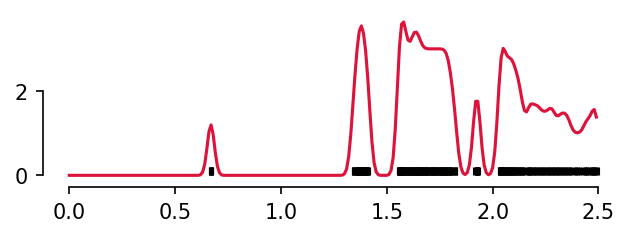

In [8]:
cell_idx = 662
trial_idx = 164

time_points = np.arange(0, spike_time_df['spike_time'].max(), time_bin)
fr = firing_rates[cell_idx, trial_idx]
st = spike_time_df[(spike_time_df.spike_cell == cell_idx+1) & (spike_time_df.spike_trial == trial_idx+1)]["spike_time"].values

fig, ax = plt.subplots(figsize=(5, 1.5), dpi=150)
ax.plot(time_points, fr, c="crimson")
ax.eventplot(st, lineoffsets=0.1, linelengths=.2, color="k")
sns.despine(trim=True)

## Population activity and behavioral analyses

##### Extract firing rate only for active trials

In [9]:
firing_rates_active = firing_rates[:, dset.active_trials.values]

In [10]:
firing_rates_active.shape

(734, 214, 250)

##### Extract the response (left, right, or nogo) of the subject for all trials.

In [11]:
response_type = dset.response_type.values[dset.active_trials.values]

##### Plot population activity (i.e. mean across neurons) averaged across trials for each of the three possible responses

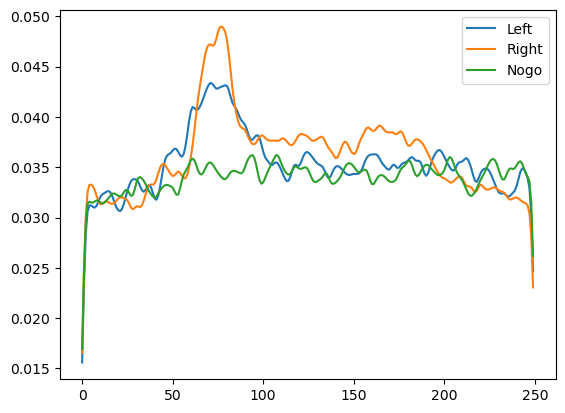

In [12]:
left_pa = firing_rates_active[:, response_type<0].mean(axis=(0, 1))
right_pa = firing_rates_active[:, response_type>0].mean(axis=(0, 1))
nogo_pa = firing_rates_active[:, response_type==0].mean(axis=(0, 1))
plt.plot(left_pa, label="Left")
plt.plot(right_pa, label="Right")
plt.plot(nogo_pa, label="Nogo")
plt.legend()

##### Do the same analysis for different brain areas (each area one subplot)

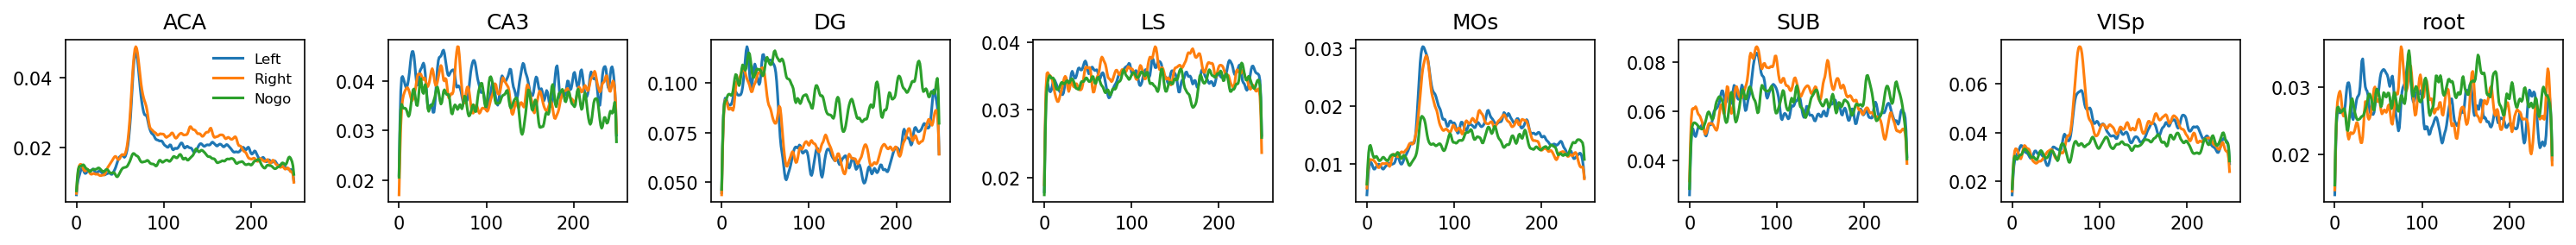

In [13]:
brain_area = dset.brain_area.values
unique_brain_areas = np.unique(brain_area)

fig, axes = plt.subplots(1, len(unique_brain_areas), figsize=(20, 2), dpi=150)

for idx, ax in enumerate(axes.flat):
    neurons_mask = brain_area == unique_brain_areas[idx]
    left_pa = firing_rates_active[neurons_mask][:, response_type<0].mean(axis=(0, 1))
    right_pa = firing_rates_active[neurons_mask][:, response_type>0].mean(axis=(0, 1))
    nogo_pa = firing_rates_active[neurons_mask][:, response_type==0].mean(axis=(0, 1))
    ax.plot(left_pa, label="Left")
    ax.plot(right_pa, label="Right")
    ax.plot(nogo_pa, label="Nogo")
    ax.set_title(unique_brain_areas[idx])

    if idx == 0:
        ax.legend(fontsize=8, frameon=False)
    
fig.tight_layout()

## Firing rate analysis: PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
data_to_get_PCs = firing_rates_active[:, :, 51:130]
n_neurons, n_trials, n_timepoints = data_to_get_PCs.shape
data_to_get_PCs = data_to_get_PCs.reshape(n_neurons, n_trials*n_timepoints)
n_components = 5
pca = PCA(n_components=n_components).fit(data_to_get_PCs.T)
n_neurons, n_trials, n_timepoints = firing_rates_active.shape
firing_rates_active_PCs = pca.transform(firing_rates_active.reshape(n_neurons, n_trials*n_timepoints).T)
firing_rates_active_PCs = firing_rates_active_PCs.T.reshape(n_components, n_trials, n_timepoints)

In [16]:
firing_rates_active_PCs.shape

(5, 214, 250)

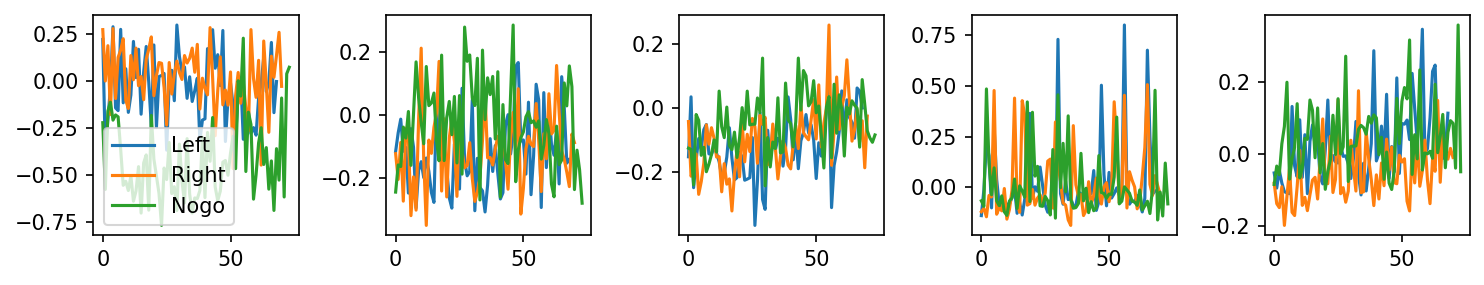

In [17]:
fig, axes = plt.subplots(1, n_components, figsize=(10, 2), dpi=150)

for idx, ax in enumerate(axes.flat):

    left_pa = firing_rates_active_PCs[idx, response_type<0].mean(axis=1)
    right_pa = firing_rates_active_PCs[idx, response_type>0].mean(axis=1)
    nogo_pa = firing_rates_active_PCs[idx, response_type==0].mean(axis=1)
    ax.plot(left_pa, label="Left")
    ax.plot(right_pa, label="Right")
    ax.plot(nogo_pa, label="Nogo")
    if idx == 0:
        ax.legend()
        
fig.tight_layout()

##### Visualize the each PC (in a separate panle) across all trials and time bins (e.g. using `plt.imshow`)

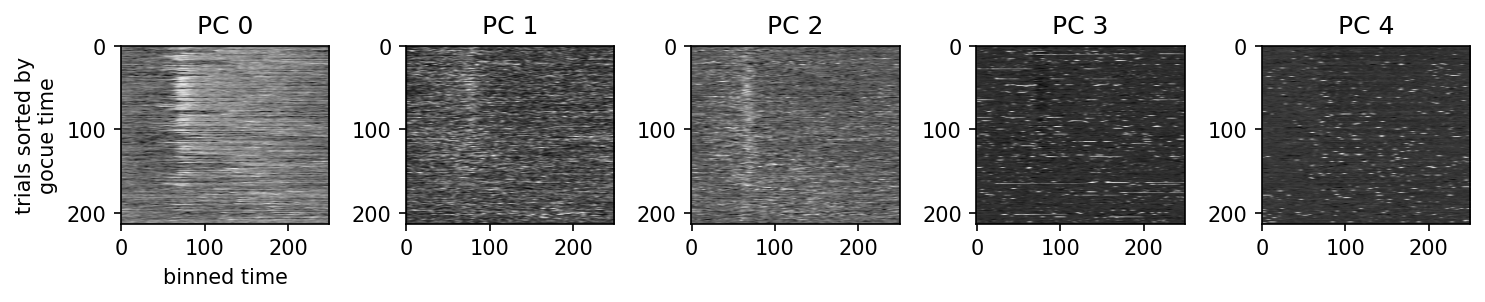

In [18]:
fig, axes = plt.subplots(1, n_components, figsize=(10, 2), dpi=150)

for idx, ax in enumerate(axes.flat):
    ax.imshow(firing_rates_active_PCs[idx], cmap='gray')
    ax.set_title(f'PC {idx}')
    if idx==0:
        ax.set(xlabel='binned time', ylabel='trials sorted by\ngocue time')
        
fig.tight_layout()

##### Sort all trials by response latency and see if the PCs care about that.

In [19]:
response_time = dset.response_time.values[dset.active_trials.values]

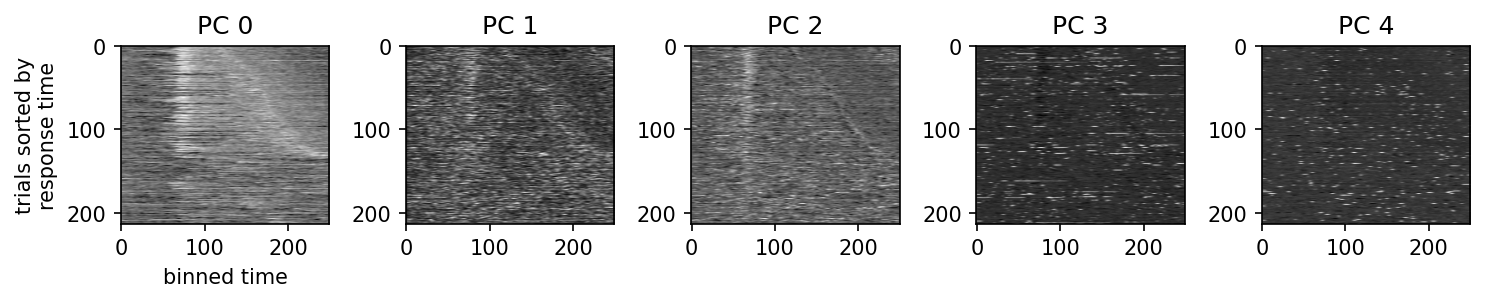

In [20]:
fig, axes = plt.subplots(1, n_components, figsize=(10, 2), dpi=150)

for idx, ax in enumerate(axes.flat):
    ax.imshow(firing_rates_active_PCs[idx, np.argsort(response_time)], cmap='gray')
    ax.set_title(f'PC {idx}')
    if idx==0:
        ax.set(xlabel='binned time', ylabel='trials sorted by\nresponse time')
        
fig.tight_layout()